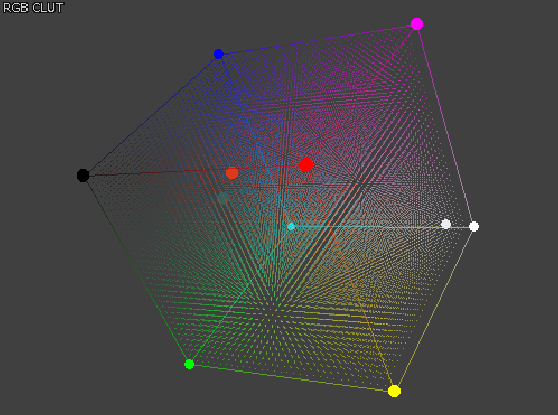

# Part 2: Dataset Curation with 1D and 3D LUTs

I'm aware of three ways to create an image enhancement dataset:

1. Get a bunch of "normal" images, and distort their colors / lighting. Then, teach network to "undo" the distortions in a supervised way.

2. Get a bunch of "normal" images, retouch them all manually, and teach a network to "enhance" normal images in a supervised way.

3. Get a bunch of "normal" images, and a bunch of "wonderful" images (which contain different subject matters), and use unpaired loss functions to learn how to map "normal" images into "wonderful" images, even though they are images of different things. This is common in tone mapping and HDR.

For fixing bad lighting and color problems, the standard way to create a dataset is to go with the first option. If we're just trying to fix "messed up" images, there is nothing limiting about this approach. A common way ML engineers create color / exposure balance datasets is by randomly multiplying scalars to color channels, or applying nonlinear filters (gamma) to the color channels. A function that will do this in pytorch is called "ColorJitter", which is actually used in non-image enhancement tasks like semantic segmentation to augment a dataset. Programmatically randomizing image channels is a good strategy for adding "underexposed" and "desaturated" images to our dataset, but for simulating color distortion, it is very limited. Here's an example of creating a color balance / exposure balance dataset with this methodology.


# Distorting a Dataset (Naively)

### Basic Imports

In [19]:
import torch
from torchvision.transforms import CenterCrop, Resize, ColorJitter
import torchvision.transforms.functional as TF
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
import cv2

url = 'https://images.pexels.com/photos/276299/pexels-photo-276299.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
image = Image.open(requests.get(url, stream=True).raw)

### Original Image

In [ ]:
IMAGE_DIM=300
width,height = image.size
dim = min(width,height)
transforms = torch.nn.Sequential(
        CenterCrop((dim,dim)),
        Resize((IMAGE_DIM,IMAGE_DIM)),
)
original = transforms(image)
original

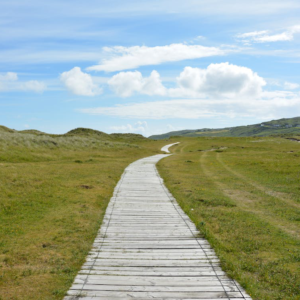

### Distorted with Scalars

The most obvious way to create a distortion dataset is to get a bunch of "regular" images, and distorted their red, blue and green channels that you would teach an ML algorithm to fix. You can either multiply by channels and then clip / normalize back to 255, or use a gamma to avoid hitting your 255 limit. It should be said that gray world assumption algorithms are good at removing distortions of this type.

In [ ]:
data = np.array(original).astype(float)

# some scalars to warm up the color temperature
red = 1.2
blue = 0.8
data[:,:,0] *= red
data[:,:,2] *= blue

data = np.clip(data,0,255)
data = Image.fromarray(data.astype(np.uint8))

# a classic recipe for warming up the lighting in an image
data

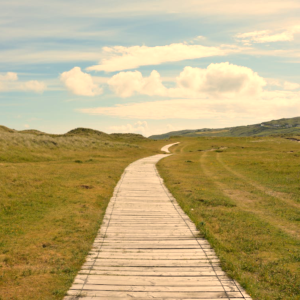

### Distorted with Gamma

As mentioned, you can perform "gamma correction" on your different channels to adjust the color temperature nonlinearly. This will already create distortions that a "gray world algorithm" cannot remove.

In [ ]:
data = np.array(original).astype(float)
data /= 255

# Distort the colors nonlinearly so that values don't go out of bounds
red = 1 / 1.5
blue = 1 / 0.8
data[:,:,0] = data[:,:,0] ** red
data[:,:,2] = data[:,:,2] ** blue

data *= 255
data = Image.fromarray(data.astype(np.uint8))

# Warmer, but in a weird non-linear way: the grass is more red than the sky
data

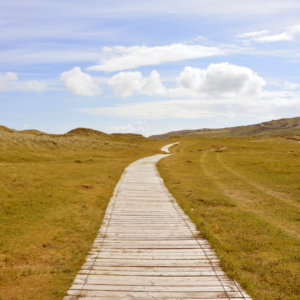

### Distorting Saturation

In [ ]:
# Convert to Hue, Saturation and Value Space
data = np.array(original)
data = cv2.cvtColor(data,cv2.COLOR_RGB2HSV).astype(float)
data = data / 255

desaturation = 0.5
data[:,:,1] *= desaturation

data = data * 255
data = np.clip(data,0,255).astype(np.uint8)
data = cv2.cvtColor(data,cv2.COLOR_HSV2RGB)
data = Image.fromarray(data)

# Observe a washed out / uncolorful version of our original meadow
data

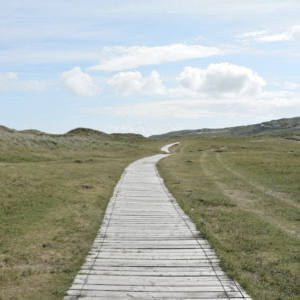

### Distorting the Hue

You can mess with the hue of an image this way as well, but I only suggest doing this for dataset augmentation purposes (if you're training an image classifier or something unrelated). If you augmented an image enhancement dataset this way, you might as well be learning how to "colorize" black and white images. Your network woud overfit and not be generally useful.

In [ ]:
# Convert to Hue, Saturation and Value Space
data = np.array(original)
data = cv2.cvtColor(data,cv2.COLOR_RGB2HSV).astype(float)
data = data / 255

hue = 0.5
data[:,:,0] *= hue

data = data * 255
data = np.clip(data,0,255).astype(np.uint8)
data = cv2.cvtColor(data,cv2.COLOR_HSV2RGB)
data = Image.fromarray(data)

# What have we done?
data

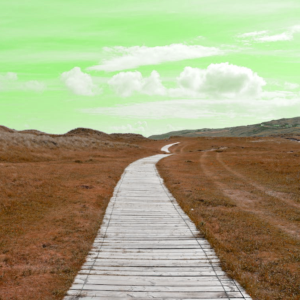


# Limitations of Perturbing RGB/HSV Channels Randomly

1. **Too Easy or Too Hard**: If you stick to adjusting channels with multiplicative scalars or gamma, you can only create datasets with images that have comparatively simple distortions. If you can remove a warm or cool tone, who cares? On the other hand, if you really mess around with the hue, or apply some truly random nonlinear filters to your color channels, you probably won't converge on a network that generalizes well.
2. **Data Inefficient**: When you're designing a dataset for this purpose, I find you don't need to uniformly approximate all possible color imbalances. Your neural network is smarter than you think it is. You also might undersample images with common distortions like "neon" that you want your network to have a lot of data for, and you will most definitely oversample a lot of color filters that just don't really exist in the real world (but might exist in alien worlds or extradimensinoal ones)
3. **3D Color Mapping Distortions**: You won't be able to neutralize tones or instagram filters because these distotions map 3D color coordinates to other ones in specific ways. If you're modifying the channels independently, you cannot capture those filters.



The most "state of the art" deep learning algorithms use Look Up Tables, so I've added a somewhat extensive section on how to design datasets and retouch photos with 1D and 3D LUTs.


# Introducing Look Up Tables (LUTs)

"LUT" stands for Look Up Table. These are **discrete** functions that act like hash tables. When you apply a LUT to an image, you go through every pixel in your image, find its coordinate in the LUT, and replace that pixel's color with what the LUT tells you.


A 3D LUT is a very complex mapping such that every possible pixel color is mapped to a new one. In cinema, these 3D LUTs applied during postprocessing give each movie its own vibe. Horror movies will map gray values to either blue or green, darken shadows and desaturate faces. Wes Anderson films appear to map gray values to yellow, lighten the overall appearance, increase saturation in oranges and map blue into teal (although it's an ongoing community effort to design the perfect Wes Anderson LUT filters)

### 1D LUTs for Shadows, Midtones and Highlights

A 1D LUT will affect a channel independently of the others (and are far simpler to make and work with than 3D LUts). I've attached an image of editing a lookup table in the popular (free) software GIMP. I've gone to the Colors tab and clicked into the Curves menu, and dragged the middle of the "red" channel up. The "curve"  is a mapping from old intensity (x-axis) to new intensity (y-axis). What this operation has done is map all of the "middle" intensities of red, to a higher intensity. This is a 1D LUT because it is affecting a single channel independently.

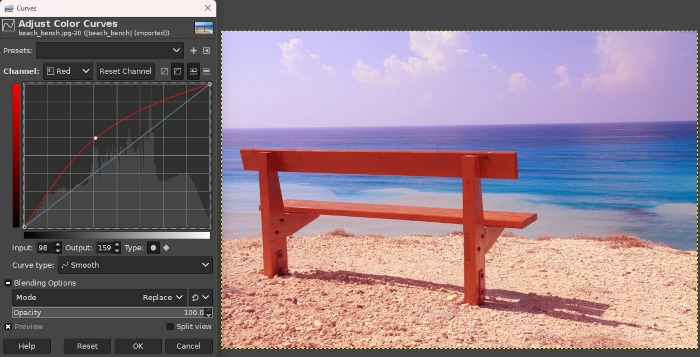

## Curves that capture the effects you want

1D LUTs can add a lot to your dataset. But as you can see, increasing the red channel alone did not create a convincing "warm" feel to my image. When building a LUT dataset, you have to get a little creative. Something that works a bit better is to subtract out blue when you want to create a warm tone, or subtract out red when you want to create a cool tone. In the below image, I've reduced the values of the mid to high level blues, in order to create a warmer look. I've left the darker parts of the blue channel alone, as these are unrelated to "lighting" effects. To create a convincing "neon" look, I would advise to subtract out green and then add in either red or blue. I've modified all the tones slightly, because artificial neon lights tend to change the value of all the pixels in a scene (shadows, midtones and highlights).

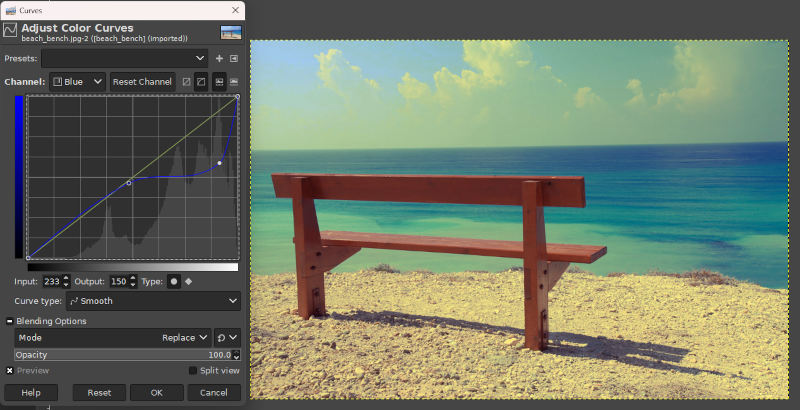

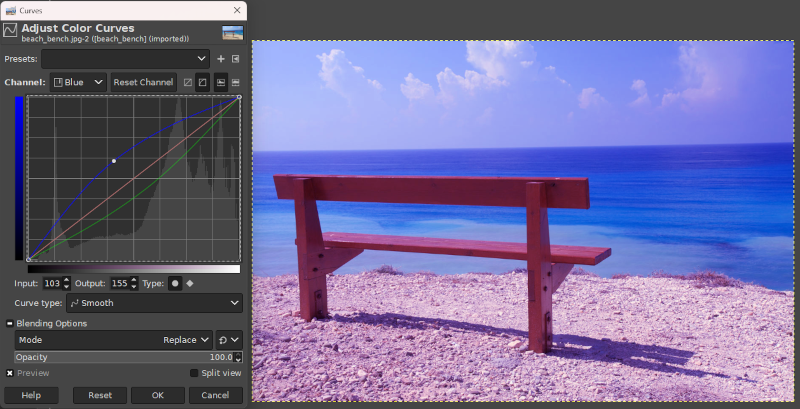

### Contrast

You can use the curves to modify contrast as well, and when creating a dataset, I suggest that you do so, so that your network doesn't just learn to remove all color contarst in the entire image. Noticed I've selected the "value" channel, which corresponds to the lightness/exposure level.

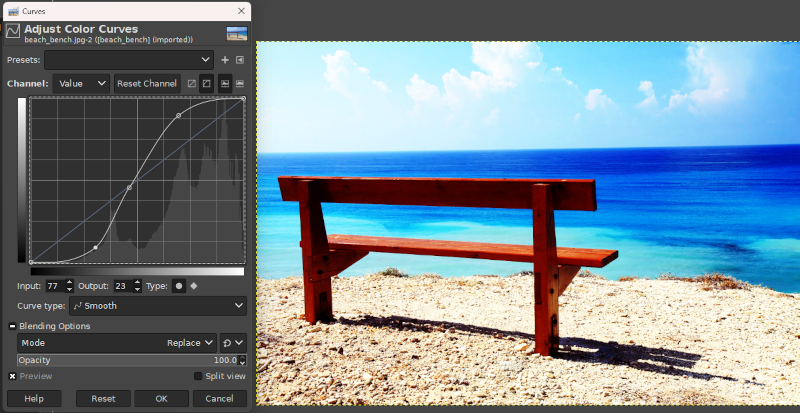

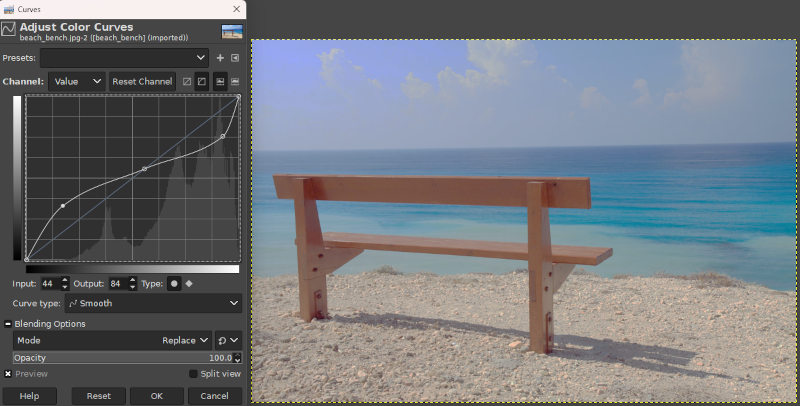

### Saving our 1D LUTs as .cube files and applying them in python

You can turn any color mapping into a .cube file (which can be applied to any image) using a HALD clut file. You can download one at:

[https://sirserch.github.io/lut-creator-js/](https://sirserch.github.io/lut-creator-js/)


These weird looking images contain every possible color (to some resolution). Distort the colors in this file using whatever you want (python, GIMP, Photoshop), and simple scripts can turn them into .cube files for you, which can apply your color mapping to any image. I would suggest following the instructions for this on this page. You don't need to download any software in order to do this, although Googling how to create LUTs will give you lots of spammy advertisements I suggest you avoid. The open github project I've linked below let's you download a HAL at three different resolutions, and processes it into a .cube file instantaneously, for free.




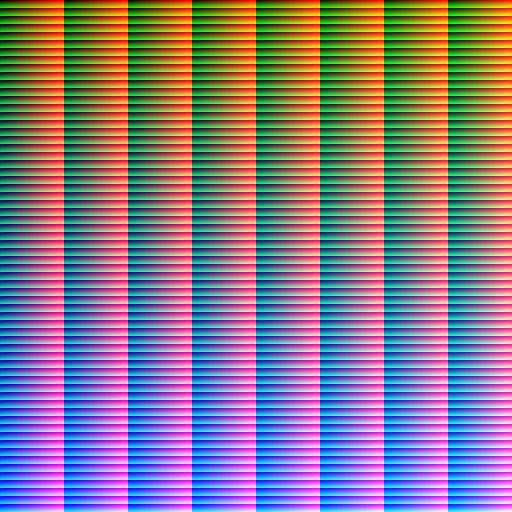

## 1D LUTs to Include in your Distortion Dataset

I recommend building up a small (< 20) LUT set of random color curves that approximate the effects that you want, using the methodology above. In addition to midtone gamma adjustments, know that green highlights are common (due to fluorescent lighting), as are blue shadows. You should make your 1D curves varied enough so that your distortions color a lot of ground, but I do **not** recommend generating these 1D curves randomly: you will get weird images that cause your network to overfit. For each image, you really only need a few LUT applications (selected randomly from your greater set) to build a sufficient dataset for removing 1D LUT distortions. In the github of this page, I've saved a few 1D LUTs that I made in GIMP that should be sufficient. Some samples of the LUTs I've made for you:

1. orange
2. extreme red
3. slight red
4. warm
5. yellow
1. cold
2. extreme blue
3. blue teal
4. storybook (green / yellow lighting mix)
5. flourescent (green highlights)
6. green midtones 
7. green teal
8. purple majesty (+ blue - green)
9. neon (+ red - green)
10. purple (+ red + blue)
11. desaturated
12. technicolor
13. dark shadows
14. over exposed
15. saturated highlights
16. underexposed

In [ ]:
# To apply our lut file, we can use the pillow-lut library
# found at https://pypi.org/project/pillow-lut/
# 
# A word of caution here: pillow isn't compatible with older versions
# of PIL, which some of the functions we need in HuggingFace's diffusers
# library relies on. I would suggest making a virtual environment with 
# the following script command:
# 
# python3 -m venv lut_env/
# cd lut_env/
# source bin/activate
#
# and perform all of your lutting here.

# In order to apply a LUT file to an image, we can use the 
# following code

from pillow_lut import load_cube_file

image = PIL.open('my_boring_image.png')
lut_file = 'cool_lut_I_made_in_GIMP.cube'
lut = load_cube_file(lut_file)
better_or_worse_image = image.filter(lut)

# "better_or_worse_image" now has whatever changes are dictated in your 
# LUT file, which reflects how you changed your HAL file in GIMP


### My Homemade 1D LUTs (and some contrast/exposure adjusters)

I made these with 64 resolution HAL files. There's a good mix of distorters in here (an equal amount per folder). I recommend randomly choosing them when you are creating a dataset to keep things balanced. [A link to this folder is here](https://github.com/messy-bytes/Advanced-ML-Color-Fixes/tree/main/LUTs/Damaging) 


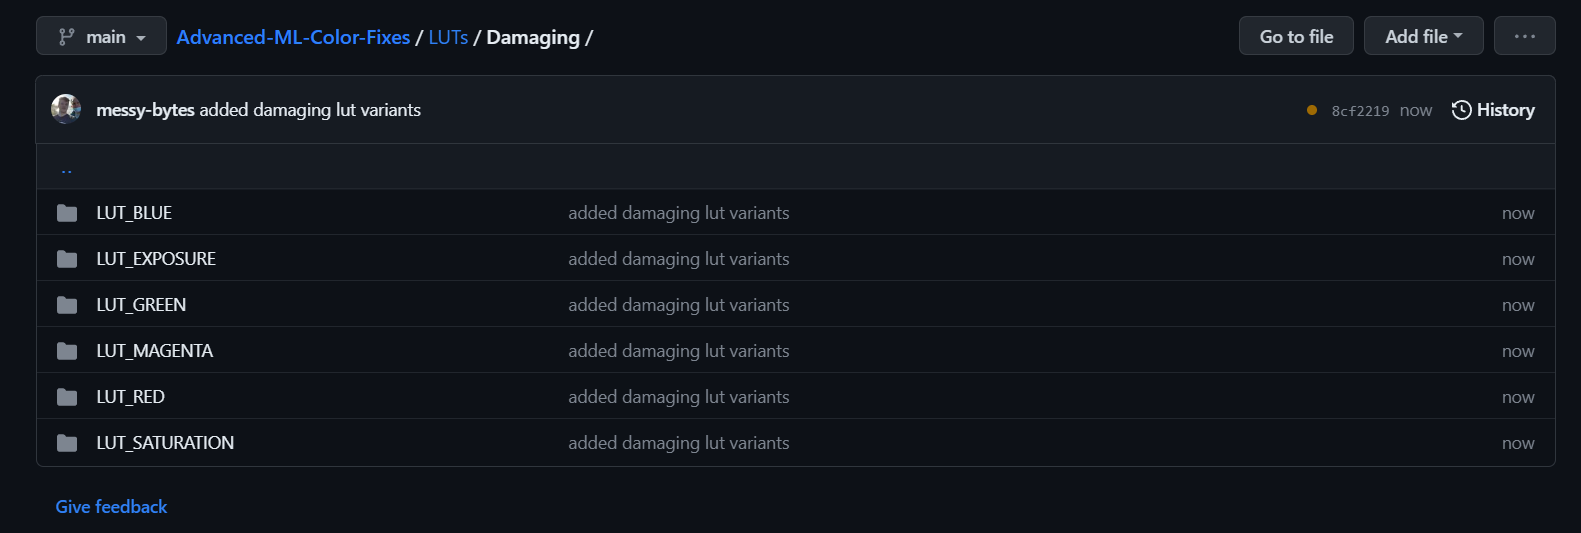

## Limitations of 1D LUTs

Making "brown" or vintage VSCO/Instagram filters with 1D curves is hard. It is also impossible to increase or reduce saturation via 1D LUTs, because saturation and hue are functions of all three colors. However, as we saw above, saturation is easy to work with programmatically: you either decrease it to make the image "less colorful", or increase it to make it "more vivid". Hue, on the other hand, is tricky: changing the fundamental colors of the image is hard to do in a useful way. Do I turn reds into pinks? Yellows into greens? In general, this process is surgical and requires skill. People sell good "color mappings" online for upwards of $20: they are that hard to mine. Good color maps that can correctly map all possible pixels to different ones (and not make the image look worse) are known as 3D LUTs.

## Playing with 3D LUTs in GIMP and GMIC

To start off, I don't recommend creating something as complicated as a 3D LUT in GIMP. I actually recommend just raiding a website that has free LUTs and using these to distort your images. I've curated some for you that should actually be enough (available in the github for this page). But GIMP has a Creative Commons License, so I'm going to use it to show you how a 3D LUT can me made on the cheap.





### 3D LUTs the Simple Way (HaldCLUT file)

Recall that a 3D LUT is a hash table that maps RGB coordinates, to different ones. While it takes a great deal of skill to make one that supports all images, you can make one very easily by simply editing a HaldCLUT file (as above), using any sliders (not just the 1D curves). GIMP's color and filter tabs have lots of sliders, but a pretty general one is the Hue-Saturation panel in the Colors tab.

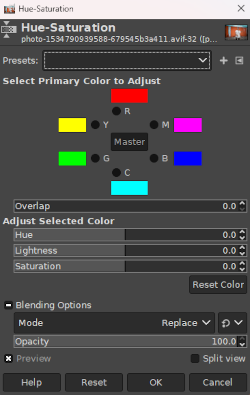

Even with this simple slider, you can create some interesting cinematic effects. Consider the image of a model below. On the top is an original image, and on the bottom is its counterpart with an "Orange and Teal" look mapped to it. 

<br>

*Disclosure*: I actually found this image in its edited state, and used the Hue-Saturation tool to "recover" what I believe is the original image out. I believe it had its blues mapped to cyan, its reds mapped to orange, and the shadows darkened. This is basically a common edit. Using the Hue-Saturation tool and a 1D value curves, I think I did a pretty good job of extracting the "before". You can tell that the "after" image is edited because of the harsh transition on the "Genstar" banner: there is an unnatural blue highlight that divides it from the rest of the image. Sometimes, applying LUTs to enhance images will result in artifacts like these. For what it's worth, I think my fix looks nicer than the heavily post processed one.

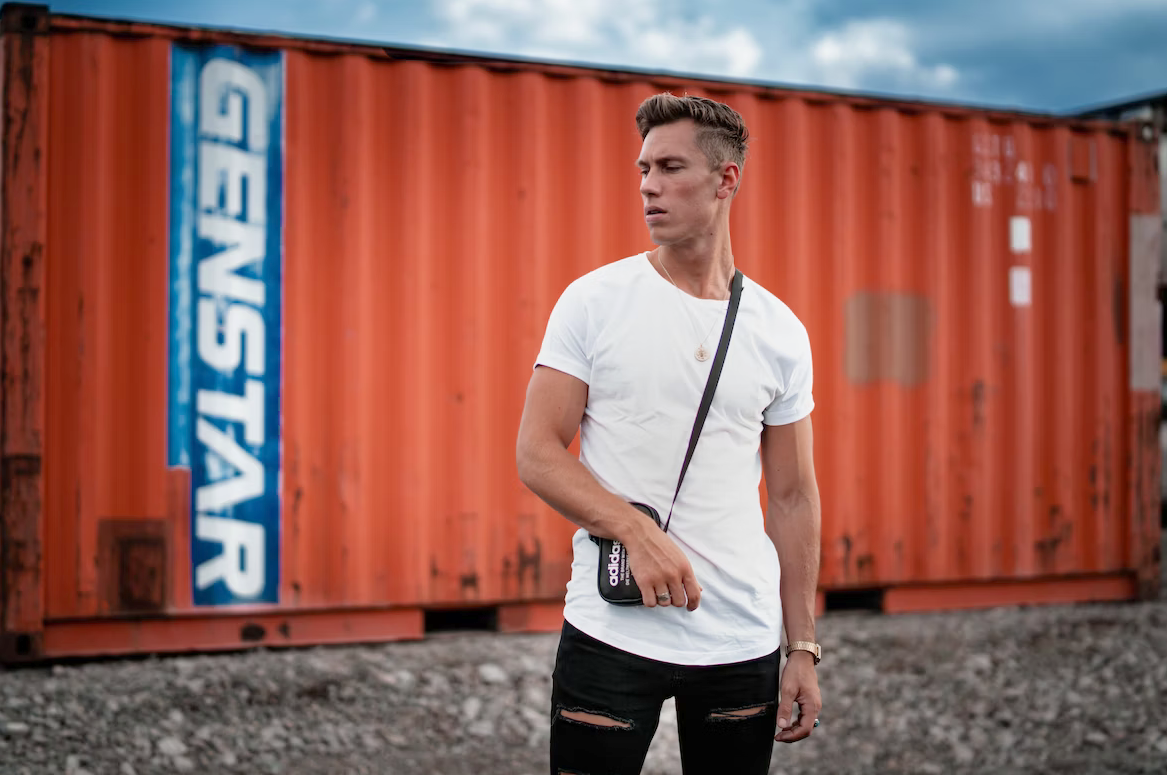

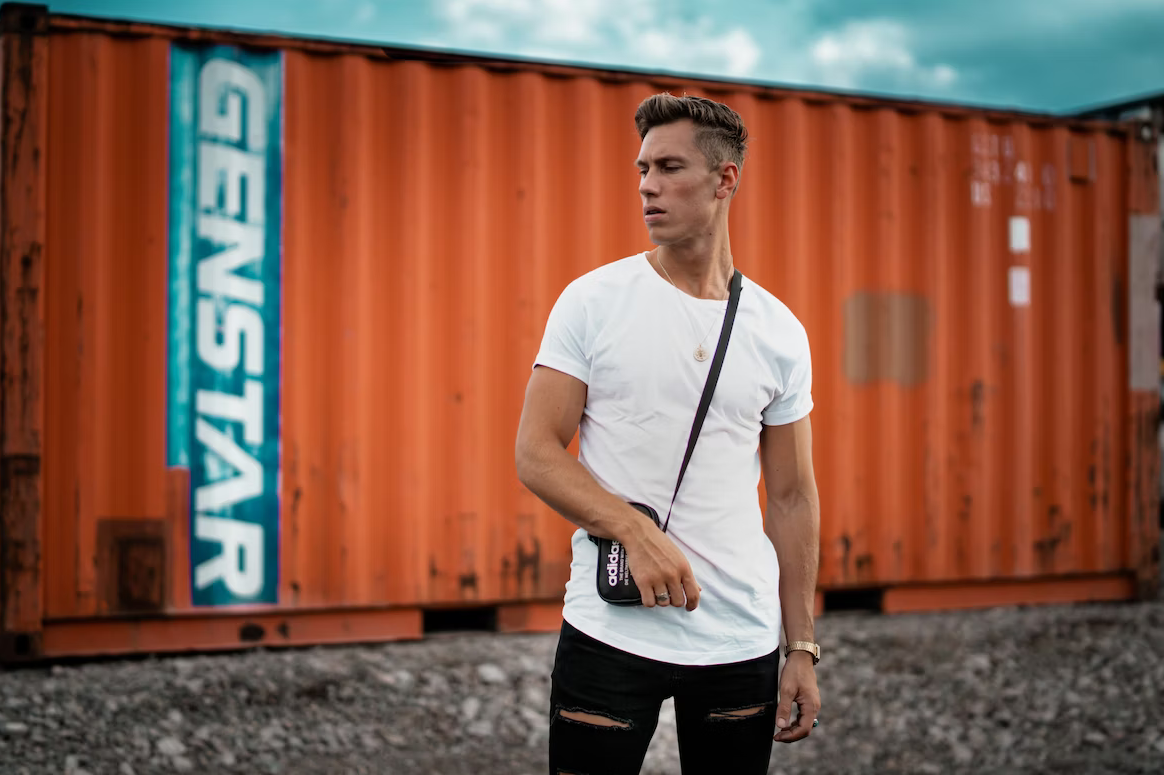

### Editing 3D Cubes with GMIC

GIMP has some fun sliders to play around with, but I would say once you feel like you can't make any more edits with the Hue-Saturation and Curves tools, then it's time to graduate to GMIC. GMIC is a filters pack worked on by a lot of individual contributors, and I think its best feature is the Customize CLUT tool. To access this tool:

1. [Download GMIC here](https://gmic.eu/download.html). It isn't its own application. Once installed, it can only be used through GIMP
2. Open GIMP, and head over to the filters tab and select G'MIC-Qt
3. In the G'MIC menu, go to the Colors tab and scroll down to Customize CLUT



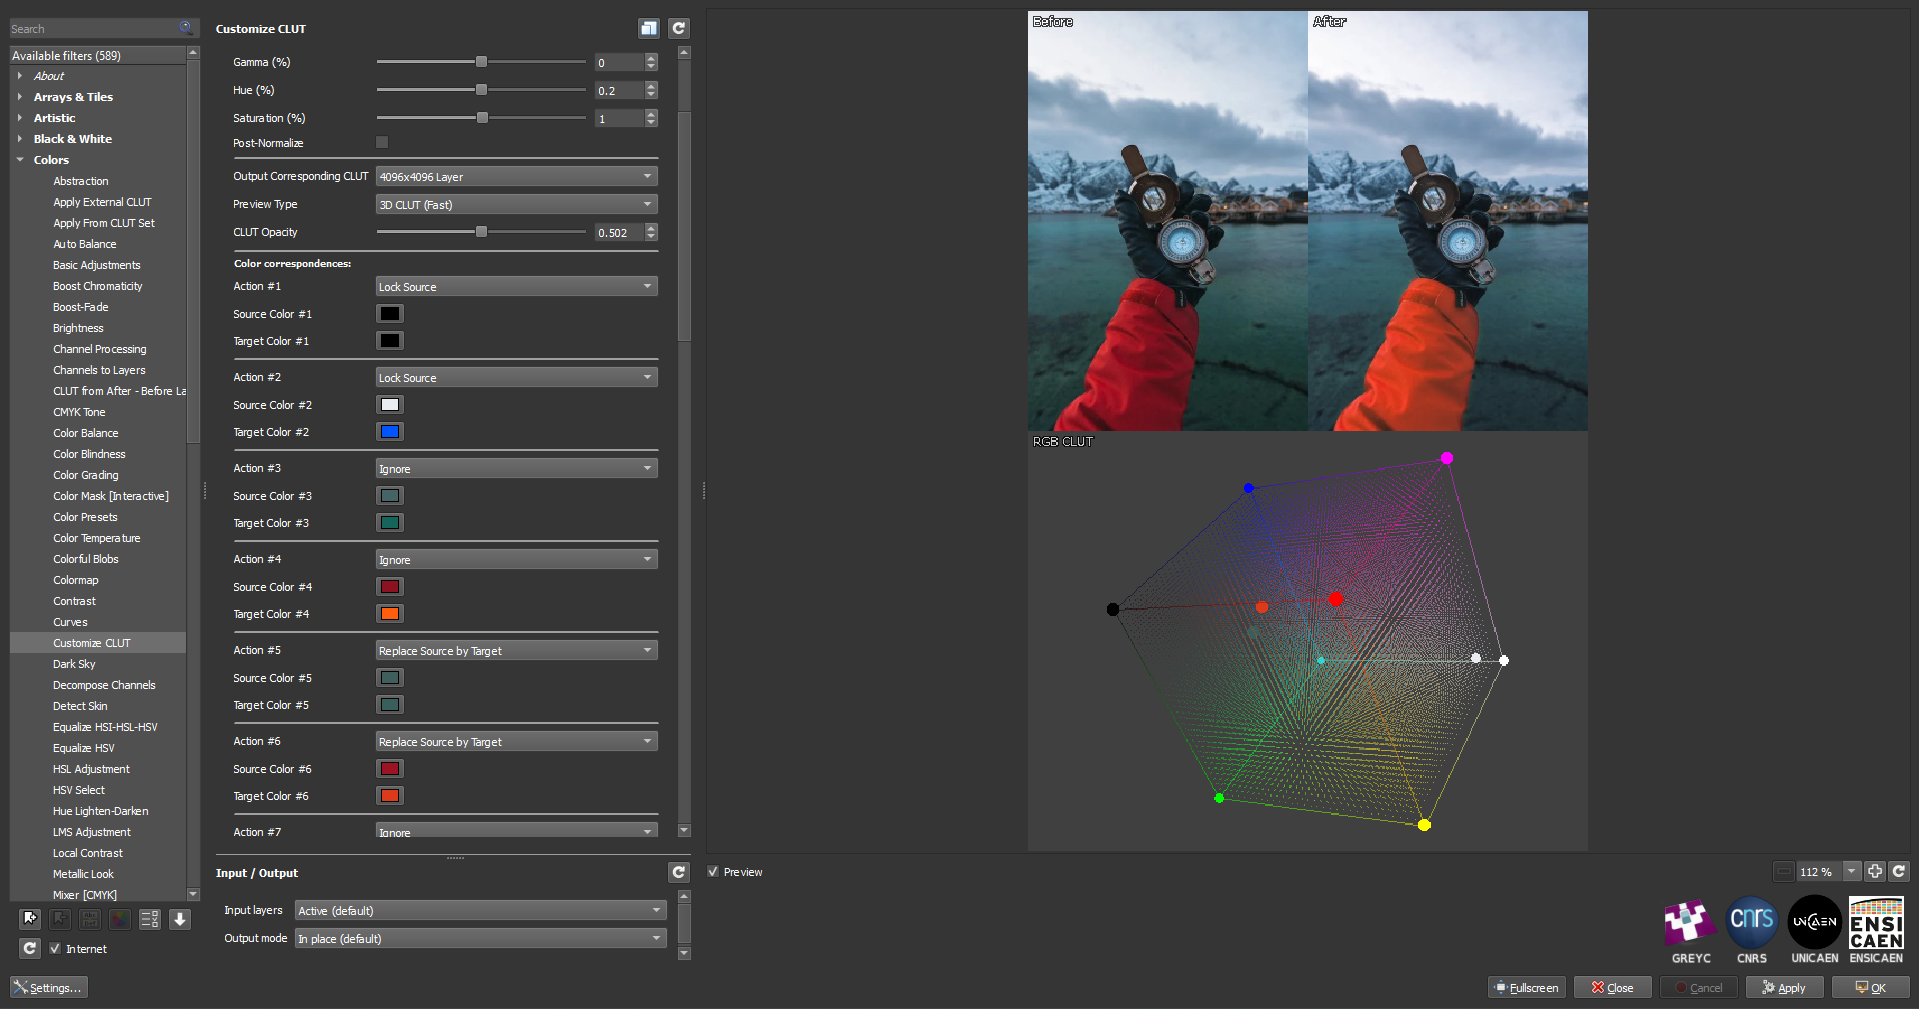

### Tips for editing a full 3D LUT

The CLUT Customize menu has a lot of familiar buttons for things like updating brightness, contrast, etc. The real power of this tool is in the "Action" items. Each action has a source and a target color, and three options:

1. **Ignore** (you can turn rules on and off quickly this way)
2. **Lock Source**: you can pick colors in your image and lock them, so the LUT learns to not change them. Right away, you should pick some white values in your image (snow, etc.) and lock them so you don't get a global color imbalance.
3. **Replace Source by Target**: This is your main weapon. In the above example, I selected the red on the jacket and replace it with orange, and replaced the water color with a more icy teal. 

I don't know how the algorithm regresses a LUT from your constraints, but I think the tool is brilliant. I have strong reason to believe they are using trilinear interpolation, which is how Hui Zeng et al learn LUTs differentiably [https://github.com/HuiZeng/Image-Adaptive-3DLUT](https://github.com/HuiZeng/Image-Adaptive-3DLUT).

## Finding LUT's online

Retouching is tedious, and making good LUTs is hard. These examples have been simple, but if we took any of these 3D LUTs we made and applied them to any image, it would probably be terrible. Real artists spend many hours designing 3D LUTs to work well with a wide range of imagery. Fortunately, there are websites with lots of free LUTs that create a wealth of cinematic effects. I recommend downloading free ".cube" files at [freshluts.com](https://freshluts.com). You'll have to sign up for a free account, but I've used them for a while and I don't find them sketchy. For dataset generation, I recommend searching them by tint (red, blue, green, magenta, brown), and just downloading a whole bunch of them. 



### My Own Handpicked LUTs from Online


I've added an artistic section for LUTs I found online. Each folder (that is labeled with a color) contains 3 LUTs: one that greatly changes the vibe of the image, one that slightly retouches it, and a medium one. The other folders have experimental LUTs and VSCO/Instagram-like filters that I also used to spice up my own dataset (to great effect). [A link to this folder is here](https://github.com/messy-bytes/Advanced-ML-Color-Fixes/tree/main/LUTs/Artistic)



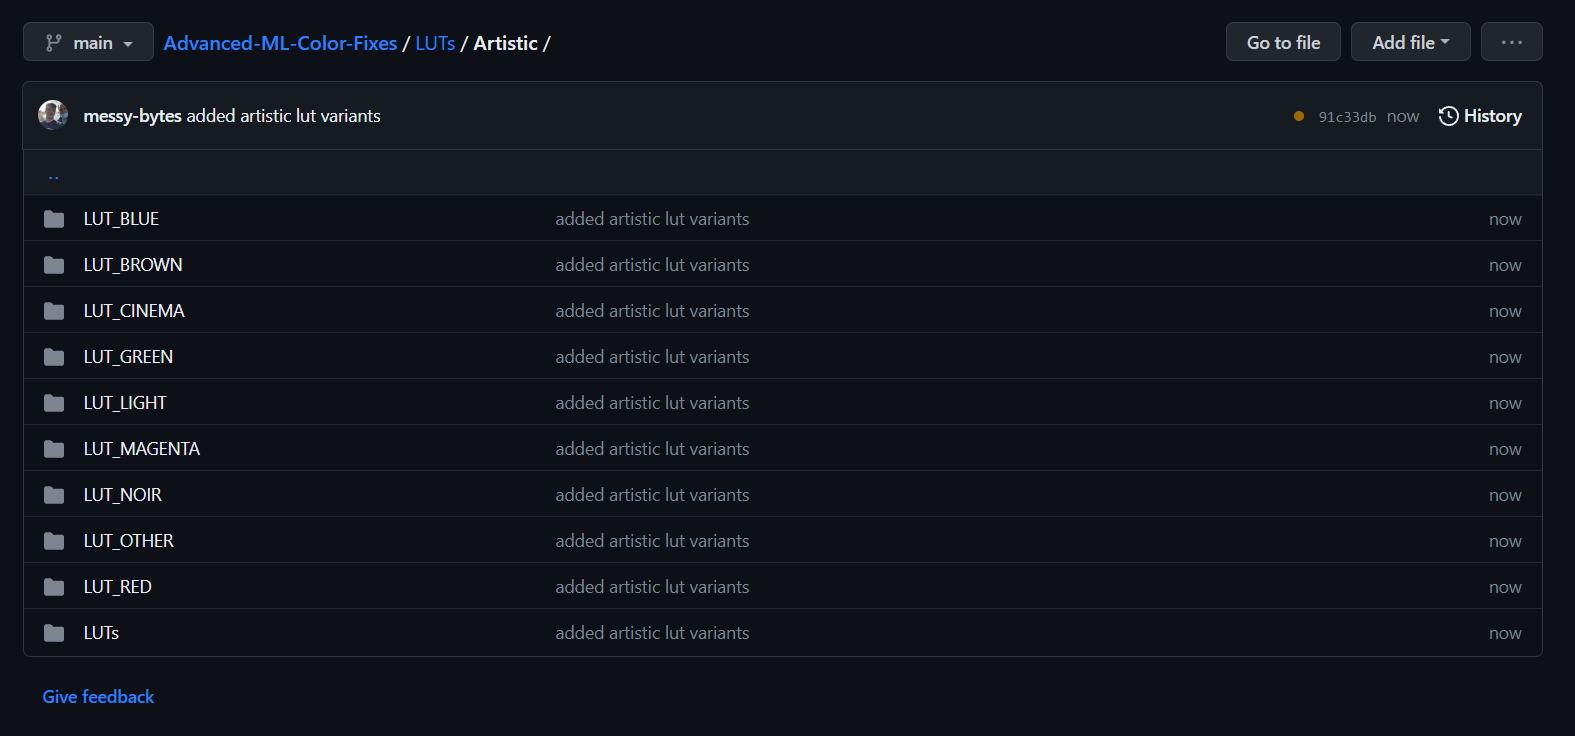

# Building a Dataset

### Where to find your images

I recommend anywhere between 5,000 to 15,000 total images (all distortions included). Although you can get very good results on just 3,000 distorted images created from 500 "true" images. I used images from:

1. **The Ava Aesthetics Dataset**: A public dataset of images curated from DP Challenge. The dataset is [here](https://github.com/ylogx/aesthetics/tree/master/data/ava) , and a paper describing it is [here](http://refbase.cvc.uab.es/files/MMP2012a.pdf) 

2. **MS Coco**: Tried and true, Coco 2017 was also used to train the autoencoder used in this project. The dataset is [here](https://cocodataset.org/#home). Note that as of 2023, the only reliable way to access this dataset is with wget

3. **PPR10K Portrait Dataset**: The only face dataset that I like for this problem, and also a project worked on by the same people who authored the seminal "Learning Image-adaptive 3D Lookup Tables for High Performance Photo Enhancement in Real-time". [Link to the portrait dataset](https://github.com/csjliang/PPR10K) 


### Basic Dataset Curation

Using the LUTs above (including your own), I recommend making some categories (red, blue, contrast, etc.), and for each ground truth image generate a distortion from each one of those categories, randomly sampling a LUT flavor each time. It's important to both have lots of variation, but to keep your red, blue, and green distortions reasonably balanced. 

Below are some of the images from the time I spent living in Vermont (although on a second glance, I think all those images are technically in New Hampshire). They are distorted with a splatter of LUTs. Notice that some are obviously warm or cool, while others are more complex color mappings. Absent, however, are random colors that wouldn't normally appear in a modern digital photograph, such as you would get by just applying color transformations by distorting images in a python loop.

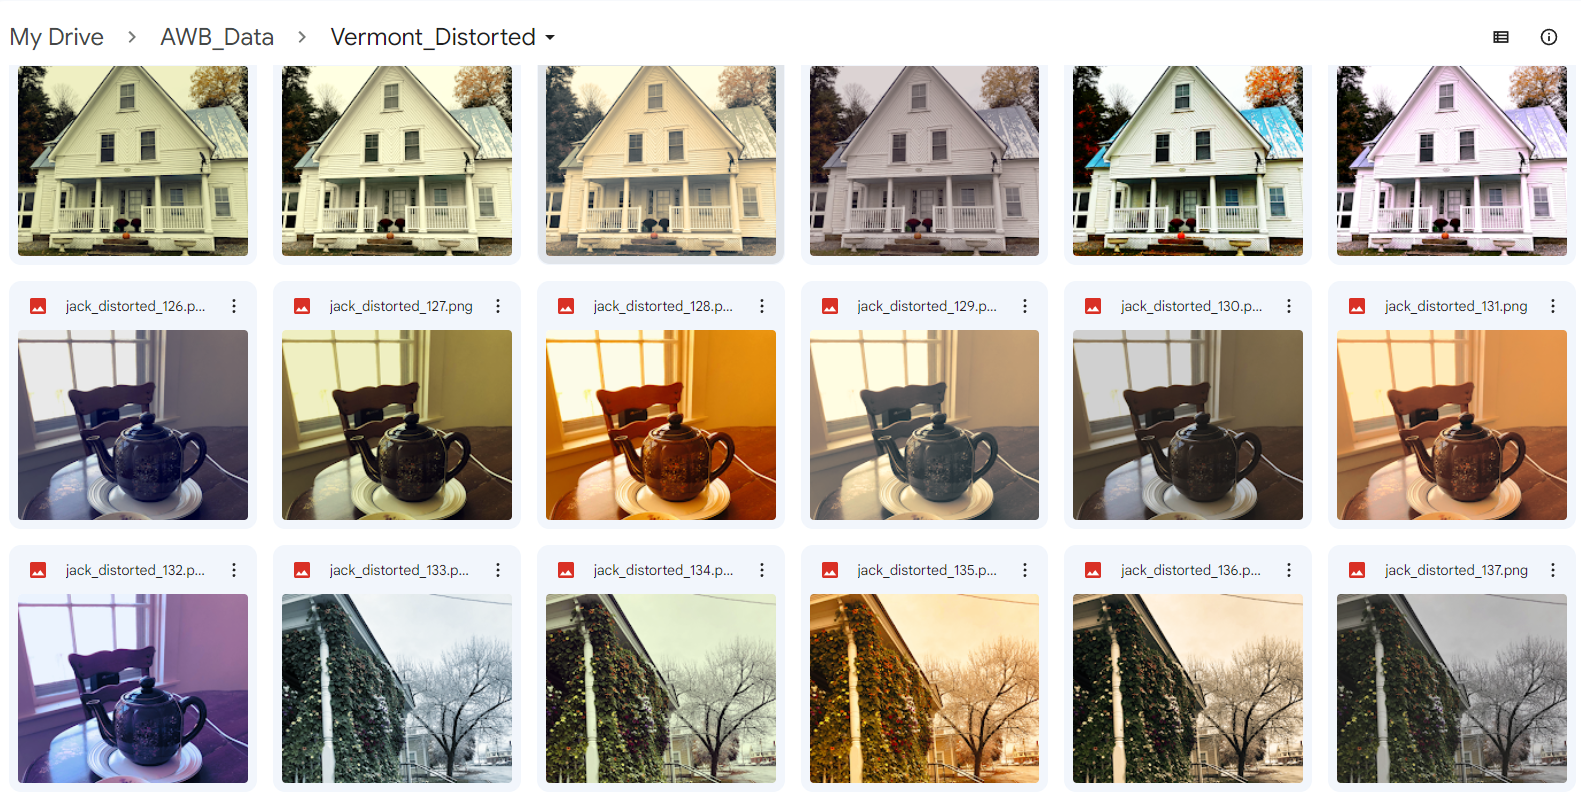

### General Enhancement LUTs (for skin tones)

Some LUTs are designed to just "generally enhance" an image. There are some really well engineered ones that you can buy at places like [Colorist Factory](https://coloristfactory.com/) that sell LUT packs for upwards of $80. A LUT set like this is designed to have a "grade" for every possible image you could throw at it. Their [blog](https://coloristfactory.com/blog/) is a really great place to learn about professional color design, but be warned: it's a huge step up in complexity from this ammateur post.

One of their LUTs, [Severn](https://freshluts.com/luts/271), is available for free on the website mentioned above, which both enhances images and cools them down. Another is [Nikon Z6](https://freshluts.com/luts/359), which warms them up. Notice that while Nikon Z6 warms faces up more, Severn still warms up the model's face, even though the overall tone it applies is "cool". I used a mix of these LUTs to improve the faces dataset I used to train a network, to prevent skin tones from being "washed out" after balancing the other colors in the image. 

Note: I "deep balanced" the colors of this image before applying the filters, so that both Nikon and Severn would look more natural. If your image is already high contrast or has weird lighting effects, applying an enhancement LUT might make it look weirder. Look at your images in your distorted dataset before you include them. They don't all have to be perfect, but if some just look horrible you should throw those out.


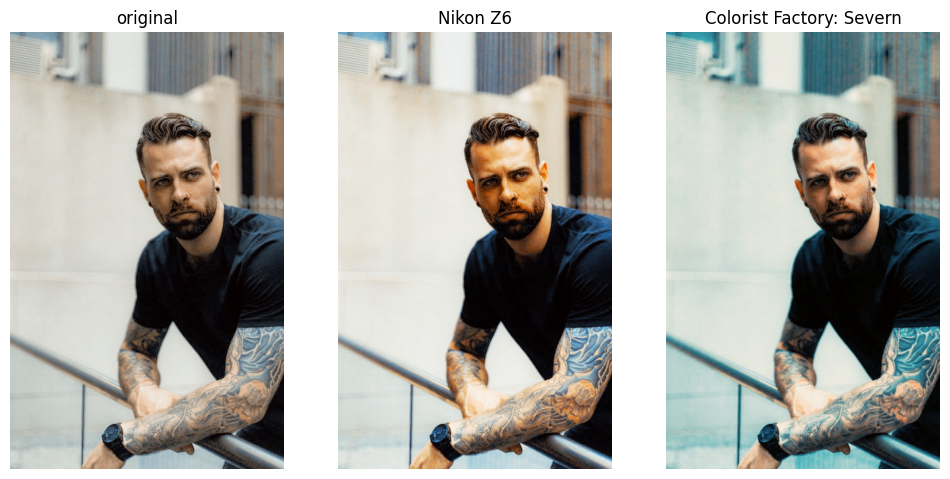